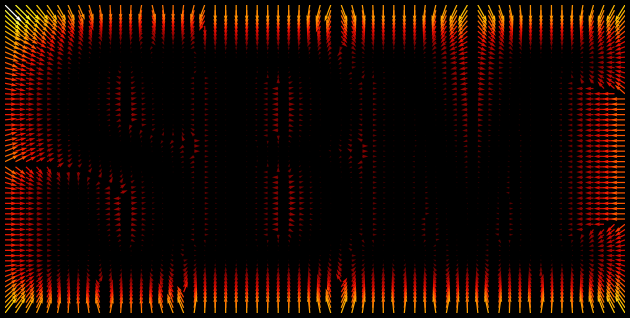

In [107]:
from score_models.plot_utils import *
import torch.distributions as tfd
from torch.func import vmap, grad

# Step 1: Render the letters in matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.text(0.5, 0.5, "SBM", fontsize=120, ha='center', va='center')
ax.axis("off")
fig.canvas.draw()

# Step 2: Convert the rendered figure to a grayscale image and extract pixel data
image = np.array(fig.canvas.renderer.buffer_rgba())
plt.close(fig)
image_gray = np.mean(image[:, :, :3], axis=2)  # Convert to grayscale

# Step 3: Get non-zero pixel locations (centers of Gaussians)
coords = np.column_stack(np.where(image_gray > 200))  # Threshold to detect letters
coords = coords - np.mean(coords, axis=0)  # Center coordinates around (0, 0)
coords = torch.tensor(coords, dtype=torch.float32) / 100  # Scale down for distribution
coords = torch.stack([coords[:, 1], -2*coords[:, 0]]).T  # Shuffle, flip, rescale coordinates

# # Step 4: Define a Gaussian Mixture Model and its score
def logp(x, coords=coords, sigma=1e-2):
    energy = ((x.view(1, -1) - coords)**2).sum(1) / (2 * sigma**2)
    return torch.logsumexp(-energy, 0)
    
def score(x):
    return vmap(grad(logp))(x)

fig = plt.figure(figsize=(8, 4))
ax = plt.gca()
extent = (-2, 2, -1.75, 1.75)
cmap = cc.cm.fire
plot_score(score, ax=ax, n=60, cmap=cmap, width=0.002, extent=extent)
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
ax.axis("off")
plt.savefig("../assets/sbm_logo.png", bbox_inches="tight", pad_inches=0)